# Pre-Layer Norm

**Goal:** According to [2002.04745](https://arxiv.org/abs/2002.04745), the location of the layer normalization in the transformer encoder layer really matters. So I've trained both of these architectures, so now I just want to try to start to compare the ...

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import yaml

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import StandardScaler


import os
os.sys.path += ['../RRevolution/code/','../RRevolution/pairingMVAs/','../pairAGraphTraining/']
from utils import getSubDir
from transformers import pairAGraph
from prepareData import getGNNDataLoaders
from train import my_nll_loss

import torch
import torch.nn.functional as F

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
physicsSample = 'SMNR'
prodTag = 'JUN20'
mc_tr = 'mc16ade'
nSelectedJets = 5

config = 'test'
num_folds = 2

trainDir = getSubDir(physicsSample, mc_tr, prodTag, nSelectedJets)

**Step 1: Compare the expectation of the weights at initialization**

First, I need to load in the architectures

In [3]:
with open('../pairAGraphTraining/configs/test.yaml', 'r') as yaml_file:
    configs = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
dataConfig = configs['dataset']
modelConfig = configs['modelParams']
optConfig = configs['training']
model =  configs['model']

In [4]:
# post-LN
modelConfig['preLN'] = False
postLN = pairAGraph(inpt_dim=5,njets=nSelectedJets,**modelConfig)

post-LayerNorm transformer


In [22]:
# pre-LN
modelConfig['preLN'] = True
preLN = pairAGraph(inpt_dim=5,njets=nSelectedJets,**modelConfig)

pre-LayerNorm transformer


Secondly, I need to load in the training datasets

In [6]:
loader_train, loader_val = getGNNDataLoaders(k=0,num_folds=2,**dataConfig)

Getting pagDataset for 2b, holding out fold 1/2
155937  train + val events
Getting pagDataset for 2b, holding out fold 1/2
132069  train + val events


In [7]:
for batch in loader_train:
    break

Finally, get the gradients

In [8]:
xi, yi, wi, bi = batch

In [9]:
lr = optConfig['lr']

o_post = torch.optim.Adam(postLN.parameters(), lr=lr)
o_pre  = torch.optim.Adam(preLN.parameters(),  lr=lr)

In [10]:
o_pre.zero_grad()

logits_i, ei = preLN(xi)
logp_i = F.log_softmax(logits_i,1)
li = my_nll_loss(logp_i,yi,wi)

li.backward()

In [23]:
for p in preLN.parameters():
    print(p.shape)

torch.Size([20, 5])
torch.Size([20])
torch.Size([60, 20])
torch.Size([60])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([60, 20])
torch.Size([60])
torch.Size([20, 20])
torch.Size([20])


In [25]:
for param_tensor in preLN.state_dict():
    print(param_tensor, "\t", preLN.state_dict()[param_tensor].size())

toLatent.weight 	 torch.Size([20, 5])
toLatent.bias 	 torch.Size([20])
encoderLayer.self_attn.in_proj_weight 	 torch.Size([60, 20])
encoderLayer.self_attn.in_proj_bias 	 torch.Size([60])
encoderLayer.self_attn.out_proj.weight 	 torch.Size([20, 20])
encoderLayer.self_attn.out_proj.bias 	 torch.Size([20])
encoderLayer.linear1.weight 	 torch.Size([20, 20])
encoderLayer.linear1.bias 	 torch.Size([20])
encoderLayer.linear2.weight 	 torch.Size([20, 20])
encoderLayer.linear2.bias 	 torch.Size([20])
encoderLayer.norm1.weight 	 torch.Size([20])
encoderLayer.norm1.bias 	 torch.Size([20])
encoderLayer.norm2.weight 	 torch.Size([20])
encoderLayer.norm2.bias 	 torch.Size([20])
finalNorm.weight 	 torch.Size([20])
finalNorm.bias 	 torch.Size([20])
finalAttnLayer.in_proj_weight 	 torch.Size([60, 20])
finalAttnLayer.in_proj_bias 	 torch.Size([60])
finalAttnLayer.out_proj.weight 	 torch.Size([20, 20])
finalAttnLayer.out_proj.bias 	 torch.Size([20])


In [32]:
'finalNorm.weight' in preLN.state_dict().keys()

True

In [44]:
for c in ['preLN','preLN_lr_0p003','btag_5j']: #,'noBinfo_5j']:

    sd = torch.load(f'../RRevolution/pairingMVAs/models/SMNR_mc16ade-JUN20-5jets/{c}_1of2/model.pt',
                    map_location='cpu')
        
    if 'finalNorm.bias' in sd.keys():
        print(f'{c} uses preLN')
    else:
        print(f'{c} not using preLN')
        
    break

preLN uses preLN


In [45]:
preLN.load_state_dict(sd)

<All keys matched successfully>

In [39]:
?preLN.load_state_dict

In [12]:
preLN.parameters

<bound method Module.parameters of pairAGraph(
  (toLatent): Linear(in_features=5, out_features=20, bias=True)
  (encoderLayer): TransformerPreLNEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=20, out_features=20, bias=True)
    )
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (finalNorm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (finalAttnLayer): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=20, out_features=20, bias=True)
  )
)>

In [13]:
for p in o_pre.param_groups[0]['params']:
    print(p.shape)

torch.Size([20, 5])
torch.Size([20])
torch.Size([60, 20])
torch.Size([60])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([60, 20])
torch.Size([60])
torch.Size([20, 20])
torch.Size([20])


In [14]:
del_W1 = next(preLN.encoderLayer.linear1.parameters()).grad
del_W2 = next(preLN.encoderLayer.linear2.parameters()).grad

In [15]:
del_W1.shape,del_W2.shape

(torch.Size([20, 20]), torch.Size([20, 20]))

In [16]:
for p in preLN.parameters():
    break
p.grad

tensor([[-1.6558e-04, -6.4781e-05, -1.1699e-04, -9.1554e-05,  1.0055e-03],
        [ 1.9629e-04,  2.7999e-04,  6.2396e-04,  2.8736e-04,  1.3562e-03],
        [-3.4957e-05,  1.2532e-04, -3.9194e-04, -1.1449e-04, -1.1952e-03],
        [ 2.7943e-05, -3.9654e-04, -8.0928e-04, -1.2734e-04,  6.2110e-04],
        [ 1.2534e-04, -7.7218e-05, -3.2259e-04,  2.3128e-04, -7.7210e-04],
        [-6.2983e-05, -2.7404e-05, -4.4624e-04, -1.2450e-04, -3.4529e-04],
        [ 3.3364e-05,  1.0546e-04, -1.2144e-03,  3.1432e-06, -6.4166e-04],
        [ 3.3687e-06,  4.1206e-04, -9.0626e-05,  2.2086e-04,  1.9652e-04],
        [-7.1045e-05, -1.5173e-04,  2.6737e-04,  2.9281e-05, -1.1748e-03],
        [-1.7192e-04, -3.5249e-05,  2.8477e-04, -6.1376e-05, -3.8754e-04],
        [-2.1795e-05,  9.9792e-05, -2.2761e-05, -4.6422e-05, -2.6408e-04],
        [ 2.9329e-05, -5.7982e-04,  6.8309e-04,  1.0547e-04, -3.0796e-04],
        [ 1.8842e-04, -1.1861e-04, -9.0299e-04, -1.1369e-05,  7.9070e-04],
        [ 1.6371e-04, -1.

**Step 2:** Compare the training metrics 

In [17]:
mdict = {}

for config in ['test','preLN','preLN_lr_0p003','preLN_dropLast']:
    for k in range(num_folds):

        filename = f'../RRevolution/pairingMVAs/models/{trainDir}/{config}_{k+1}of{num_folds}/loss_acc.json'
        with open(filename) as vfile:
            metrics = json.load(vfile)
            mdict[f'{config}{k}'] = metrics

In [18]:
trText = "$\mathbf{ATLAS}$ Simulation Internal\n"
trText += "SM NR mc16ade JUN20 MNT"

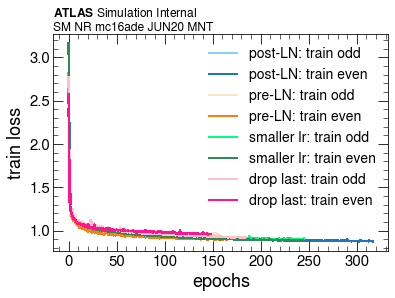

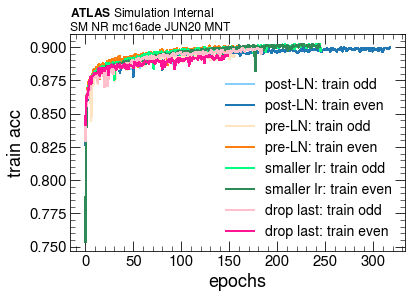

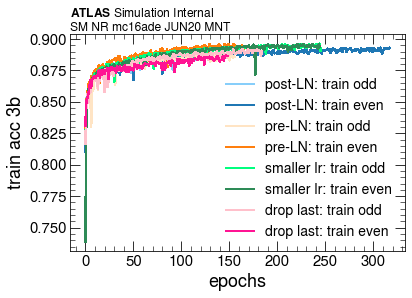

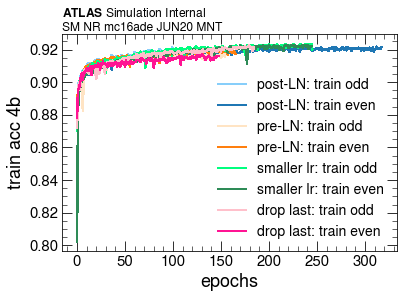

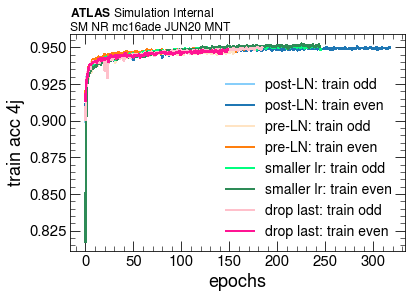

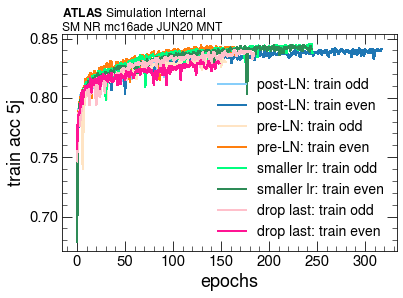

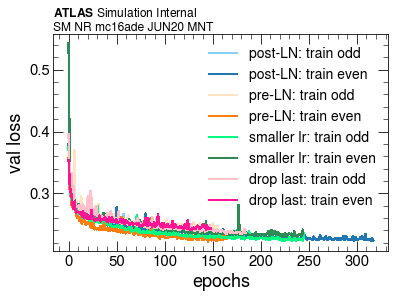

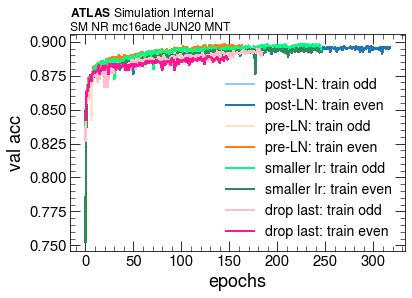

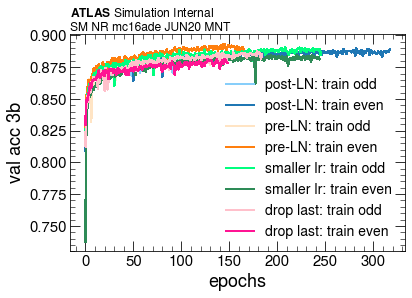

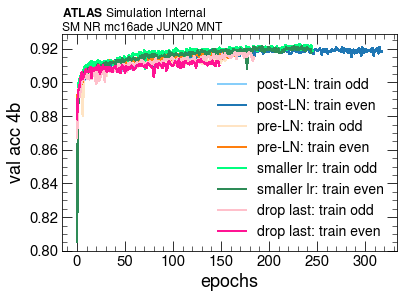

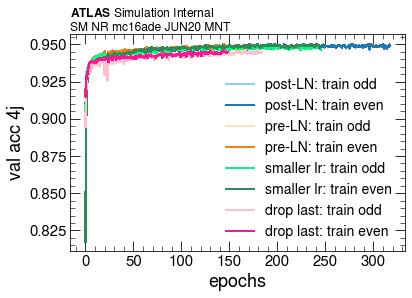

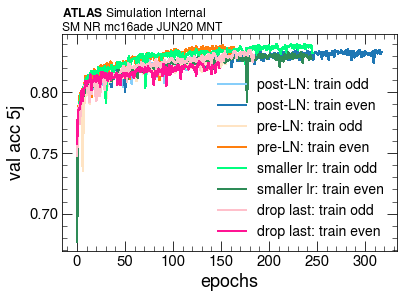

In [19]:
for k in metrics.keys():
    plt.figure()
    
    for config,l,cs in zip(['test','preLN','preLN_lr_0p003','preLN_dropLast'],['post-LN','pre-LN','smaller lr','drop last'],
                           [['lightskyblue','C0'],['bisque','C1'],['springgreen','seagreen'],['pink','deeppink']]):
        plt.plot(mdict[f'{config}0'][k],color=cs[0],label=f'{l}: train odd',lw=1.5)
        plt.plot(mdict[f'{config}1'][k],color=cs[1],label=f'{l}: train even',lw=1.5)

    plt.xlabel('epochs',fontsize=18)
    plt.ylabel(k.replace('_',' '),fontsize=18)
    plt.legend()
    
    ax = plt.gca()
    plt.text(0,1,trText,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    plt.savefig(f'figures/{physicsSample}_mc16ade-{prodTag}-{nSelectedJets}jets/{k}.pdf',bbox_inches='tight')

Ok - so it seems like the smaller learning rate is quite a bit more stable - I'll keep up w/ it for a bit now.

**Step 3:** Compare some of the histograms as we propagate through the cutflow

**Conclusion:**